## Assignment 01. Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display
%load_ext autoreload

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [2]:
# In colab run this cell
#! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/utils.py -nc
#! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/features.py -nc

In [3]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

In [4]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   should_ban    1000 non-null   int64 
 1   comment_text  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [6]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [7]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [8]:
# task: preprocess each comment in train and test

texts_train = np.array([preprocess(s) for s in texts_train]) #<YOUR CODE>
texts_test = np.array([preprocess(s) for s in texts_test]) #<YOUR CODE>

In [9]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [10]:
%autoreload 2
from features import BoW
from nltk import RegexpTokenizer

# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(RegexpTokenizer(r"\w+").tokenize(' '.join(texts_train)))))

#<YOUR CODE>
bow = BoW(k)
bow.fit(texts_train)

print('example features:', sorted(bow.get_vocabulary())[::100])

example features: ['0', '2011', '8', 'additionally', 'alllllllllllllllllllllllllllllll', 'appropriately', 'audacity', 'behind', 'bootleg', 'cake', 'chavo', 'coeditor', 'considered', 'cozy', 'dear', 'determined', 'distribution', 'editing', 'er', 'eyesights', 'finder', 'freeway', 'girlfriend', 'habit', 'hide', 'ideas', 'info', 'israel', 'kindergarten', 'lends', 'loser', 'mckenna', 'moderation', 'naturally', 'notorious', 'original', 'people', 'plus', 'priyanka', 'pussy', 'record', 'requirements', 'rollback', 'secluded', 'show', 'socialogical', 'star', 'subtract', 'tan', 'tho', 'transform', 'understood', 'variation', 'ways', 'women', 'உதவ']


In [11]:
X_train_bow = bow.transform(texts_train)
X_test_bow = bow.transform(texts_test)

In [12]:
X_train_bow.shape

(500, 5544)

In [13]:
# Small check that everything is done properly
# bow_vocabulary = bow.get_vocabulary()
# k_max = len(set(' '.join(texts_train).split()))
# assert X_train_bow.shape == (len(texts_train), min(k, k_max))
# assert X_test_bow.shape == (len(texts_test), min(k, k_max))
# assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
# assert len(bow_vocabulary) <= min(k, k_max)
# assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

In [14]:
X_train_bow.shape

(500, 5544)

Now let's do the trick with `sklearn` logistic regression implementation:

In [15]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

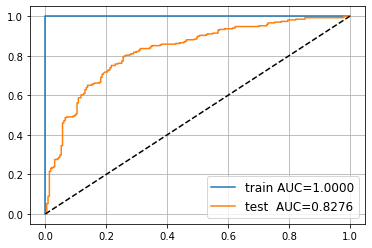

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [17]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [18]:
from utils import plot_train_process

In [19]:
X_train_bow.shape, y_train.shape

((500, 5544), (500,))

In [20]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(in_features=X_train_bow.shape[1], out_features=2))
### YOUR CODE HERE
### YOUR CODE HERE

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [21]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [22]:
opt = torch.optim.Adam(model.parameters()) ### YOUR CODE HERE

In [23]:
# lr_scheduler = StepLR(opt, step_size=2, gamma=0.5)
lr_scheduler = ReduceLROnPlateau(opt)

In [24]:
X_train_bow_torch = torch.tensor(X_train_bow, dtype=torch.float32) ### YOUR CODE HERE
X_test_bow_torch = torch.tensor(X_test_bow, dtype=torch.float32) ### YOUR CODE HERE

y_train_torch = torch.tensor(y_train, dtype=torch.long) ### YOUR CODE HERE
y_test_torch = torch.tensor(y_test, dtype=torch.long) ### YOUR CODE HERE

Let's test that everything is fine

In [25]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [26]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [27]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):
        model.train(True)

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model.forward(x_batch) ### YOUR CODE

        # compute loss, just like before
        ### YOUR CODE
        loss = loss_function(y_predicted, y_batch)
        
        # compute gradients
        ### YOUR CODE
        loss.backward()
        
        # Adam step
        ### YOUR CODE
        opt.step()
        
        # clear gradients
        ### YOUR CODE
        opt.zero_grad()

        local_train_loss_history.append(loss.item())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            model.train(False)
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

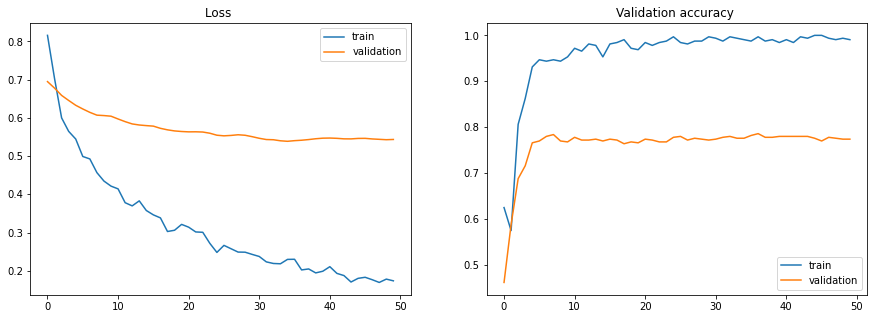

Sequential(
  (l1): Linear(in_features=5544, out_features=2, bias=True)
)

In [28]:
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, n_iterations=500)

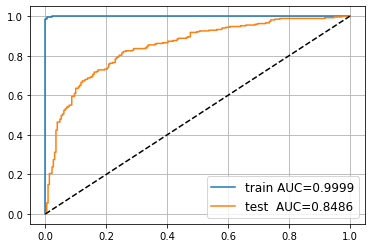

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

model.train(False)
for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [30]:
# Your beautiful code here

# let's use sklearn Logit implementation, as it showed better score
from tqdm import tqdm

def run_experiment(texts_train, texts_test, y_train, y_test, ks):
    """
    texts_train: train dataset
    texts_test: test dataset
    ks: list of k values
    """
    
    ks = np.where(ks < len(set(' '.join(texts_train).split())), ks, len(set(' '.join(texts_train).split())))
    scores = []
    
    for k in tqdm(ks):
        bow = BoW(k)
        bow.fit(texts_train)
        X_train = bow.transform(texts_train)
        X_test = bow.transform(texts_test)
        model = LogisticRegression().fit(X_train, y_train)
        score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        scores.append(score)
        
    assert len(ks) == len(scores)
    
    return ks, scores

In [31]:
ks, scores = run_experiment(texts_train, texts_test, y_train, y_test, np.arange(4000, 5544))

100%|██████████| 1544/1544 [10:13<00:00,  2.52it/s]


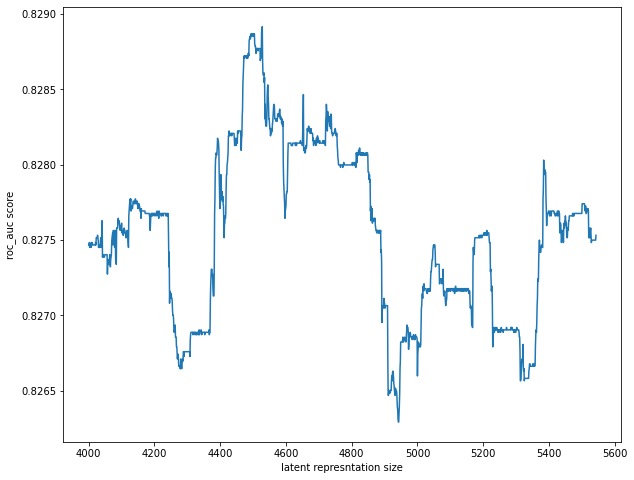

In [32]:
plt.figure(figsize=(10, 8))
plt.plot(ks, scores)
plt.xlabel('latent represntation size')
plt.ylabel('roc_auc score')
plt.show()

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [31]:
%autoreload 2
from features import TfIdf
from nltk import RegexpTokenizer

# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(RegexpTokenizer(r"\w+").tokenize(' '.join(texts_train)))))

#<YOUR CODE>
tfidf = TfIdf(k, normalize=True)
tfidf= tfidf.fit(texts_train)

In [32]:
X_train_tfidf = tfidf.transform(texts_train)
X_test_tfidf = tfidf.transform(texts_test)

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [33]:
### YOUR CODE HERE
model = nn.Sequential()
model.add_module('l1', nn.Linear(in_features=X_train_tfidf.shape[1], out_features=2))

loss_function = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model.parameters(), lr=1e-3) ### YOUR CODE HERE

lr_scheduler = ReduceLROnPlateau(opt)

In [34]:
X_train_tfidf_torch = torch.tensor(X_train_tfidf, dtype=torch.float32) ### YOUR CODE HERE
X_test_tfidf_torch = torch.tensor(X_test_tfidf, dtype=torch.float32) ### YOUR CODE HERE

y_train_torch = torch.tensor(y_train, dtype=torch.long) ### YOUR CODE HERE
y_test_torch = torch.tensor(y_test, dtype=torch.long) ### YOUR CODE HERE

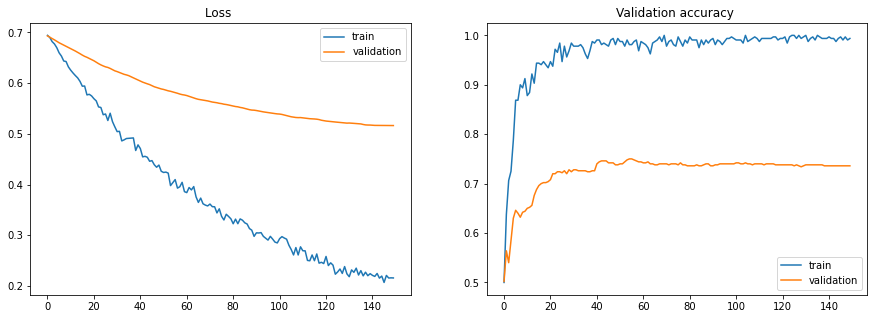

Sequential(
  (l1): Linear(in_features=5544, out_features=2, bias=True)
)

In [35]:
train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=1500)

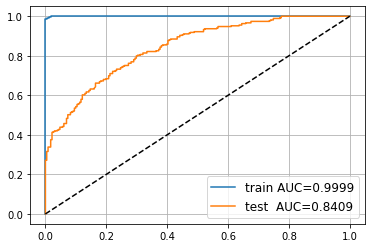

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve

model.train(False)

for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train, model),
    ('test ', X_test_tfidf_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

According to https://scikit-learn.org/stable/modules/naive_bayes.html, MultinomialNB could better perform on tfidf, when BernoulliNB on bow

Let's try them both

In [37]:
# Your beautiful code here
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

#### BoW

In [38]:
multinomial_nb_bow = MultinomialNB()
bernoulli_nb_bow = BernoulliNB()

multinomial_nb_bow.fit(X_train_bow, y_train)
bernoulli_nb_bow.fit(X_train_bow, y_train)

BernoulliNB()

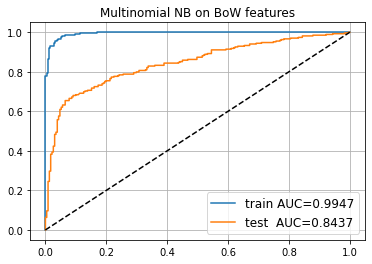

In [39]:
for name, X, y, model in [
    ('train', X_train_bow, y_train, multinomial_nb_bow),
    ('test ', X_test_bow, y_test, multinomial_nb_bow)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.title('Multinomial NB on BoW features')
plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

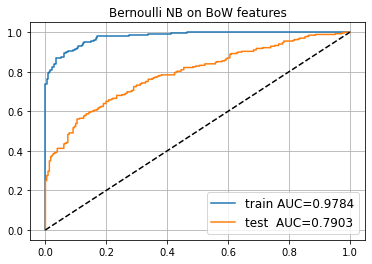

In [40]:
for name, X, y, model in [
    ('train', X_train_bow, y_train, bernoulli_nb_bow),
    ('test ', X_test_bow, y_test, bernoulli_nb_bow)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.title('Bernoulli NB on BoW features')
plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

#### TFiDF

In [41]:
multinomial_nb_tfidf = MultinomialNB()
bernoulli_nb_tfidf = BernoulliNB()

multinomial_nb_tfidf.fit(X_train_tfidf, y_train)
bernoulli_nb_tfidf.fit(X_train_tfidf, y_train)

BernoulliNB()

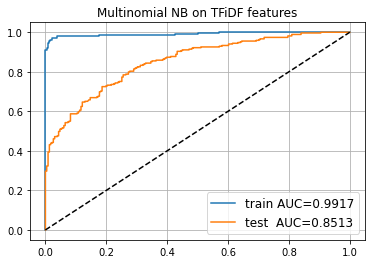

In [42]:
for name, X, y, model in [
    ('train', X_train_tfidf, y_train, multinomial_nb_tfidf),
    ('test ', X_test_tfidf, y_test, multinomial_nb_tfidf)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.title('Multinomial NB on TFiDF features')
plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

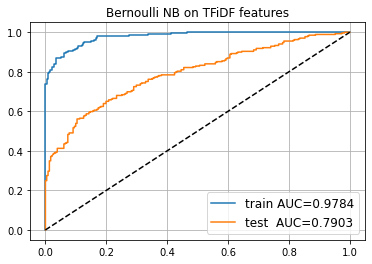

In [43]:
for name, X, y, model in [
    ('train', X_train_tfidf, y_train, bernoulli_nb_tfidf),
    ('test ', X_test_tfidf, y_test, bernoulli_nb_tfidf)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.title('Bernoulli NB on TFiDF features')
plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

_Your beautiful thoughts here_

- Multinomial NB with tfidf features showed the best result. That kind of result was expected, because of NB great performance on short text classification: https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf

- LR and LR scheduler tuning helped a lot, and torch logit showed better than sklearn's result 

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [51]:
# Your beautiful code here
import gensim.downloader as api

model = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [67]:
from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+')

def as_matrix(text):
    m = []
    for s in text:
        tokens = tokenizer.tokenize(s)
        vectorized = np.array([model[token]
                               if token in model
                               else np.zeros(model.vector_size)
                               for token in tokens])                
        m.append(np.mean(vectorized, axis=0))
    return np.array(m)

In [72]:
X_train_glove_torch = torch.tensor(as_matrix(texts_train), dtype=torch.float32)
X_test_glove_torch = torch.tensor(as_matrix(texts_test), dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [76]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(in_features=X_train_glove_torch.shape[1], out_features=2))

loss_function = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model.parameters(), lr=1e-3) ### YOUR CODE HERE

lr_scheduler = ReduceLROnPlateau(opt)

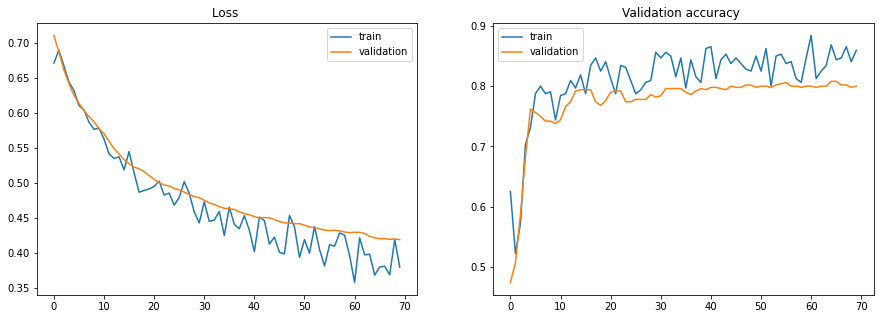

Sequential(
  (l1): Linear(in_features=100, out_features=2, bias=True)
)

In [77]:
train_model(model, opt, lr_scheduler, X_train_glove_torch, y_train_torch, X_test_glove_torch, y_test_torch, n_iterations=700)

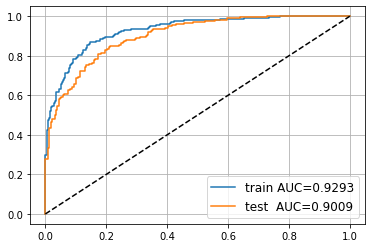

In [78]:
from sklearn.metrics import roc_auc_score, roc_curve

model.train(False)

for name, X, y, model in [
    ('train', X_train_glove_torch, y_train, model),
    ('test ', X_test_glove_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

#### Conclusion:

Pretrained on twitter glove shoved the best result 